# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [11]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

In [108]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import yfinance as yf
import time
import numpy as np

## Get the list of stocks in the S&P 500

In [13]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())
df_tickers.info()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             503 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


In [14]:
ticker_list = df_tickers['Symbol'].tolist()
print(ticker_list)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'XYZ', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DDOG', '

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [26]:
def fetch_news_for_ticker(symbol: str):
    try:
        ticker = yf.Ticker(symbol)
        return ticker.news
    except Exception as e:
        print(f"Error con {symbol}: {e}")
        return []

def build_news_dict(ticker_list):
    news_dict = {}
    for idx, symbol in enumerate(ticker_list, start=1):
        news_dict[symbol] = fetch_news_for_ticker(symbol)
        time.sleep(0.1)
    return news_dict

sample_tickers = ticker_list

news_dict = build_news_dict(sample_tickers)
display(news_dict['MMM'])

[{'id': '2f475c52-e043-3340-9129-7f18b3fdb18d',
  'content': {'id': '2f475c52-e043-3340-9129-7f18b3fdb18d',
   'contentType': 'STORY',
   'title': '3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer',
   'description': '',
   'summary': 'We recently published 12 Stocks Jim Cramer Talked About. 3M Company (NYSE:MMM) is one of the stocks Jim Cramer recently discussed. 3M Company (NYSE:MMM) is one of the largest industrial conglomerates in the world. Its shares have gained 16.7% year-to-date as part of a bullish run in industrial stocks that Cramer has commented on several […]',
   'pubDate': '2025-07-24T09:03:00Z',
   'displayTime': '2025-07-24T09:03:00Z',
   'isHosted': True,
   'bypassModal': False,
   'previewUrl': None,
   'thumbnail': {'originalUrl': 'https://media.zenfs.com/en/insidermonkey.com/093e1a4edd0e304bc17c1f522a735210',
    'originalWidth': 1000,
    'originalHeight': 667,
    'caption': '3M Company (MMM): "I Was Surprised" By The Organic Growt

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [38]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

def convert_dict_to_dataframe(news_dict):
    records = []
    for symbol, articles in news_dict.items():
        for art in articles:
            records.append({
                'ticker': symbol,
                'title': art.get('title'),
                'summary': art.get('summary', ''),
                'publish_time': pd.to_datetime(art.get('providerPublishTime'), unit='s', utc=True),
                'url': art.get('link')
            })
    return pd.DataFrame(records)

df_news = convert_dict_to_dataframe(news_dict)

df_news.head()

records = []
for ticker in ticker_list:
    for news in news_dict[ticker]:
        content = news.get("content", {})
        if content is None:
            continue
        records.append({
            "TICKER": ticker,
            "TITLE": content.get("title"),
            "SUMMARY": content.get("summary", ""),
            "PUBLICATION_DATE": pd.to_datetime(
                content.get("displayTime"), utc=True
            ),
            "URL": content.get("canonicalUrl", {}).get("url")
        })


df_news = pd.DataFrame(records)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...
...,...,...,...,...,...
5013,ZTS,Here’s Wedgewood Partners’ Investment Thesis f...,"Wedgewood Partners, an investment management c...",2025-07-21 11:36:11+00:00,https://finance.yahoo.com/news/wedgewood-partn...
5014,ZTS,Is Zoetis (ZTS) a Unique Dividend Play in the ...,Zoetis Inc. (NYSE:ZTS) is included among the 1...,2025-07-19 01:25:46+00:00,https://finance.yahoo.com/news/zoetis-zts-uniq...
5015,ZTS,"Argus Trims Zoetis (ZTS) Price Target to $190,...",Zoetis Inc. (NYSE:ZTS) is one of the high-marg...,2025-07-18 18:45:48+00:00,https://finance.yahoo.com/news/argus-trims-zoe...
5016,ZTS,Why Zoetis (ZTS) Could Beat Earnings Estimates...,Zoetis (ZTS) has an impressive earnings surpri...,2025-07-18 16:10:02+00:00,https://finance.yahoo.com/news/why-zoetis-zts-...


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [39]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

model = SentenceTransformer('all-MiniLM-L6-v2')

df_news['EMBEDDED_TEXT'] = df_news['TITLE']
df_news['EMBEDDINGS'] = df_news['EMBEDDED_TEXT'].apply(lambda x: model.encode(x))
df_news.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455427, -0.109047554, -0.07995972, 0.026..."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.0216293, -0.07978322, -0.025434958, 0.0075..."
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...,"Stock Market News for Jul 21, 2025","[-0.037469547, -0.043813713, 0.02352598, 0.107..."
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.080801524, -0.029800754, -0.03165096, 0.04..."
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.01950261, -0.07280385, 0.04442304, -0.0564..."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [97]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

df_unique_news = df_news.drop_duplicates(subset='TICKER', keep='first').reset_index(drop=True)

print("Number of rows (per ticker):", len(df_unique_news))

Number of rows (per ticker): 502


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [98]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Convertir las embeddings a una matriz de numpy

X = np.vstack(df_unique_news['EMBEDDINGS'].values)
n_unique = np.unique(X, axis=0).shape[0]
print(f"Unique embeddings: {n_unique}")
k_values = list(range(2, 8))
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=100,
        max_iter=300,
        random_state=42
    )
    labels = kmeans.fit_predict(X)
    if k > 1:
        score = silhouette_score(X, labels)
    else:
        score = np.nan
    silhouette_scores.append(score)
    print(f"Silhouette score for k={k}: {score:.4f}")

Unique embeddings: 429
Silhouette score for k=2: 0.0517
Silhouette score for k=3: 0.0548
Silhouette score for k=4: 0.0339
Silhouette score for k=5: 0.0318
Silhouette score for k=6: 0.0354
Silhouette score for k=7: 0.0356


#### Plot silhouette scores

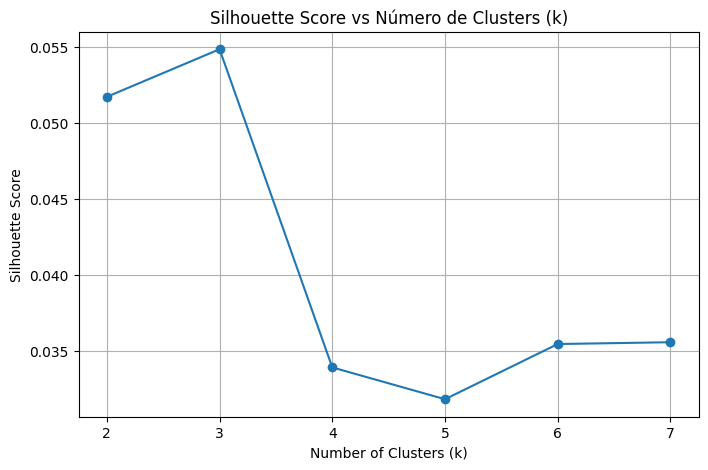

In [99]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Número de Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### Identify the Best k

In [100]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"Best k: {best_k} with silhouette score: {best_score:.4f}")


Best k: 3 with silhouette score: 0.0548


#### Cluster the embeddings using 3 clusters (k=3)

In [102]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

k = 3
kmeans = KMeans(
    n_clusters=k,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42
)
df_unique_news['cluster'] = kmeans.fit_predict(X)

print(df_unique_news[['TICKER', 'TITLE', 'cluster']])

    TICKER                                              TITLE  cluster
0      MMM  3M Company (MMM): “I Was Surprised” By The Org...        2
1      AOS  Here's Why A.O. Smith (AOS) is a Strong Value ...        0
2      ABT  Revvity trims 2025 profit forecast as China po...        2
3     ABBV  HS market forecast to reach $7.8bn across 7MM ...        2
4      ACN  Accenture’s (ACN) Oversold Status May Offer a ...        0
..     ...                                                ...      ...
497    XYL  Aristotle Capital Exited Xylem (XYL) Despite I...        2
498    YUM  eBay Set to Report Q2 Earnings: What's in Stor...        1
499   ZBRA  Here's What to Expect From Zebra Technologies'...        1
500    ZBH  Can ISRG's Strong Q2 Procedure Volume Translat...        1
501    ZTS  Zoetis (ZTS): Buy, Sell, or Hold Post Q1 Earni...        1

[502 rows x 3 columns]


### Visualize the 2 first PCA Components of your embeddings

Explained variance ratios: [0.07657743 0.04419483]


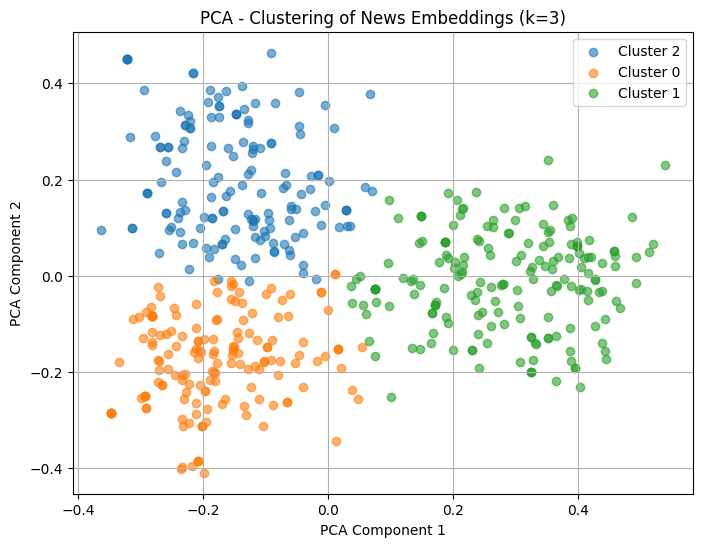

In [104]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"Explained variance ratios: {pca.explained_variance_ratio_}")


df_unique_news['pca_1'] = X_pca[:, 0]
df_unique_news['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
for cluster in df_unique_news['cluster'].unique():
    subset = df_unique_news[df_unique_news['cluster'] == cluster]
    plt.scatter(subset['pca_1'], subset['pca_2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('PCA - Clustering of News Embeddings (k=3)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [111]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

for cluster in sorted(df_unique_news['cluster'].unique()):
    print(f"Cluster {cluster}")
    cluster_df = df_unique_news[df_unique_news['cluster'] == cluster]
    print(cluster_df[['TICKER', 'TITLE']].head(5))

print("\nTop terms per cluster")
for cluster in sorted(df_unique_news['cluster'].unique()):
    texts = df_unique_news[df_unique_news['cluster'] == cluster]['TITLE']
    vec = TfidfVectorizer(stop_words='english', max_features=10)
    X_tfidf = vec.fit_transform(texts)
    terms = vec.get_feature_names_out()
    scores = X_tfidf.sum(axis=0).A1
    top = sorted(zip(terms, scores), key=lambda x: x[1], reverse=True)[:5]
    top_terms = [term for term, _ in top]
    print(f"Cluster {cluster}: {top_terms}")

Cluster 0
   TICKER                                              TITLE
1     AOS  Here's Why A.O. Smith (AOS) is a Strong Value ...
4     ACN  Accenture’s (ACN) Oversold Status May Offer a ...
6     AMD  AMD stock jumps on 3 catalysts, Boeing faces p...
12   AKAM  Akamai Technologies (AKAM) Stock Declines Whil...
13    ALB  S&P 500 Gains & Losses Today: Supermicro, Nike...
Cluster 1
   TICKER                                              TITLE
7     AES  AES to Report Q2 Earnings: What's in Store for...
9       A  Agilent Technologies' Q3 2025 Earnings: What t...
15   ALGN  What To Expect From Align Technology’s (ALGN) ...
16   ALLE  Allegion Second Quarter 2025 Earnings: Beats E...
17    LNT  Alliant Energy’s Quarterly Earnings Preview: W...
Cluster 2
  TICKER                                              TITLE
0    MMM  3M Company (MMM): “I Was Surprised” By The Org...
2    ABT  Revvity trims 2025 profit forecast as China po...
3   ABBV  HS market forecast to reach $7.8bn across 7MM ..



## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

Larger transformer models tend to produce higher-quality embeddings with richer contextual information. This can lead to more meaningful clusters and better separation between news topics. However, they also come with increased computational costs. MiniLM provides a good balance of speed and performance, but it may miss subtle nuances compared to larger models like BERT-large or RoBERTa.

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

Using only the title might capture the main topic concisely but miss context. Using only the summary adds more detail but may dilute the central idea. Combining both could offer a more complete representation. Empirically, you can test this by generating embeddings for each case, clustering them separately, and comparing silhouette scores and cluster interpretability.

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

t-SNE and UMAP are better at preserving local structure in high-dimensional data, making them more suitable when visualizing complex or nonlinear relationships. If the clusters are not clearly separated with PCA, switching to t-SNE or UMAP might reveal underlying patterns. However, they are less interpretable and more sensitive to parameter tuning.


---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

Ambiguity of topics: News about different companies can share similar language, making clusters less distinct.
Strategy: Use named entity recognition or sector-based grouping to refine cluster content.

Overlapping content: Titles may lack enough variance for effective separation.
Strategy: Combine title and summary or add metadata like sector/industry to enrich embeddings.

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

Yes, a few points were distant from any cluster center. To handle them, compute the distance from each point to its assigned cluster centroid and flag those beyond a threshold (e.g., 95th percentile). In production, these could be filtered out or analyzed separately as potentially anomalous or breaking news.

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

Based on the top keywords and example titles for each cluster, I would assign the following themes:

* Cluster 0: "Stock Market Reactions & Valuation"
This cluster contains news related to market performance, stock ratings, and valuation opportunities. Keywords like "stock", "buy", and "market", as well as titles discussing catalysts and value picks, support this interpretation.

* Cluster 1: "Earnings Reports and Forecasts"
Articles in this group focus heavily on company earnings, forecasts, and quarterly results. Keywords such as "q2", "earnings", "report", and "estimates" are prominent, and the titles reflect a consistent pattern of upcoming or recently released earnings data.

* Cluster 2: "General Business Developments & Market Deals"
This cluster appears to include broader news stories about product launches, new initiatives, deals, and market trends. Terms like "new", "deal", and "prices", along with titles discussing company-level developments and market shifts, support this theme.

I am moderately confident in these assignments. The themes seem coherent based on both the keywords and example titles. However, news content can be nuanced, and keyword overlap across themes can cause ambiguity.

To validate these labels systematically, I could:

Use topic modeling (e.g., LDA or BERTopic) to independently assess topic structures.

Perform manual annotation on a random sample of articles from each cluster.

Compute cluster purity or normalized mutual information (NMI) if labeled data is available.

Collect user feedback or conduct inter-annotator agreement studies if this were part of a deployed system.


---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

Incorporating sentiment could split clusters further into positive vs. negative news. For example, earnings reports could be grouped not just by topic but also by market reaction. This helps investors assess sentiment trends across sectors or time periods.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

K-means assumes spherical clusters and equal variance, which rarely holds for textual embeddings. It’s also sensitive to initialization. Alternatives:

DBSCAN: Handles arbitrary shapes and identifies outliers, ideal for noisy data.

Agglomerative clustering: Better for hierarchical or nested structures.

HDBSCAN: Combines advantages of both and automatically determines number of clusters.

Use these when data shows uneven cluster density or non-spherical distribution.

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.


1. News Embedding + Clustering (current approach)
2. Sentiment Analysis
3. Map news to stock tickers and dates
4. Collect stock returns (e.g., 1-day, 3-day post-news)
5. Group returns by cluster & sentiment
6. Statistical testing: Check if some clusters correlate with higher/lower returns.
7. Train a predictive model (e.g., logistic regression) using cluster ID and sentiment as features.

---

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

Possible reasons:

* Clusters capture semantic similarity but not financial relevance.
* Time lag: The effect of news may not align precisely with the measured return window.
* Market already priced in the news (efficient markets).
* Noise in financial data outweighs any signal in clusters.

Solution: Incorporate more features (e.g., sentiment, volume, context) or switch to supervised learning approaches.



